In [1]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import math
import pandas as pd
import warnings

from fdiff.dataloaders.datamodules import ECGDatamodule,NASDAQDatamodule, NASADatamodule, MIMICIIIDatamodule, USDroughtsDatamodule, Datamodule
from fdiff.utils.fourier import spectral_density, smooth_frequency, localization_metrics
from pathlib import Path
from yaml import safe_load
from typing import Any
from itertools import product

plt.style.use('science')
warnings.filterwarnings("ignore")

/home/jonathan/anaconda3/envs/fdiff/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_path = Path.cwd() / "../data/"

datasets: dict[str, Datamodule] = {
    "ECG": ECGDatamodule(data_dir=data_path),
    "MIMIC-III": MIMICIIIDatamodule(data_dir=data_path, n_feats=40),
    "NASDAQ-2019": NASDAQDatamodule(data_dir=data_path),
    "NASA-Charge": NASADatamodule(data_dir=data_path),
    "NASA-Discharge": NASADatamodule(data_dir=data_path, subdataset="discharge"),
    "US-Droughts": USDroughtsDatamodule(data_dir=data_path)
}

In [3]:
save_dir = Path.cwd() / "../outputs/"

if not (save_dir / "figures").exists():
    (save_dir / "figures").mkdir(parents=True)    
if not (save_dir / "tables").exists():
    (save_dir / "tables").mkdir(parents=True)  

# Measuring Localization on Datasets

In [62]:
EPS = 1e-15

spectral_data: list[dict] = []
temporal_data: list[dict] = []
localization_data: list[dict] = []
localization_data_joint: list[dict] = []

for dataset_name, datamodule in datasets.items():
    
    # Prepare data
    datamodule.prepare_data()
    datamodule.setup()
    
    # Extract training features
    X_train = datamodule.X_train
    
    # Compute specral representation
    X_spec = spectral_density(X_train)
    
    # Compute mean and standard error of the normalized spectral density
    X_spec_norm_mean = torch.mean((X_spec.sum(dim=2, keepdim=True) / (EPS + X_spec.sum(dim=(1, 2), keepdim=True))), dim=(0,2))
    X_spec_norm_se = torch.std((X_spec.sum(dim=2, keepdim=True) / X_spec.sum(dim=(1, 2), keepdim=True)), dim=(0,2)) / math.sqrt(len(X_spec))
    
    
    # Compute normalized frequency
    freq_norm = [k / (X_spec.shape[1]-1) for k in range(X_spec.shape[1])]
    
    
    # Record the spectral data
    spectral_data.extend(
        [
            {
        "Dataset": dataset_name,
        "Normalized Frequency": freq_norm[k],
        "Normalized Spectral Density": X_spec_norm_mean[k].item(),
        "SE": X_spec_norm_se[k].item()
            } for k in range(len(freq_norm))
        ] 
        )
    
    # Compute the mean and standard error of the normalized energy
    X_energy_mean = torch.mean((X_train**2).sum(dim=2, keepdim=True) / (EPS +(X_train**2).sum(dim=(1, 2), keepdim=True)), dim=(0, 2))
    X_energy_std = torch.std((X_train**2).sum(dim=2, keepdim=True) / (X_train**2).sum(dim=(1, 2), keepdim=True), dim=(0, 2))
    
    # Compute the normalized time
    time_norm = [k / (X_train.shape[1]-1) for k in range(X_train.shape[1])]
    
    # Record the temporal data
    temporal_data.extend(
        [
            {
        "Dataset": dataset_name,
        "Normalized Time": time_norm[k],
        "Normalized Energy": X_energy_mean[k].item(),
        "SE": X_energy_std[k].item()
            } for k in range(len(time_norm))
        ] 
        )
    
    
    # Compute localization metrics
    X_loc, X_spec_loc = localization_metrics(X_train)
    
    # Record the localization data
    localization_data.extend(
        [
            {
        "Dataset": dataset_name,
        "Delocalization": X_loc[b].item(),
        "Domain": "Time"
            } for b in range(len(X_loc))
        ] 
        )
    localization_data.extend(
        [
            {
        "Dataset": dataset_name,
        "Delocalization": X_spec_loc[b].item(),
        "Domain": "Frequency"
            } for b in range(len(X_spec_loc))
        ] 
        )
    
    # Record the joint localization data
    localization_data_joint.extend(
        [
            {
        "Dataset": dataset_name,
        "Delocalization Time": X_loc[b].item(),
        "Delocalization Frequency": X_spec_loc[b].item()
            } for b in range(len(X_loc))
        ]
        )
    
spectral_df = pd.DataFrame(spectral_data)   
temporal_df = pd.DataFrame(temporal_data)
localization_df = pd.DataFrame(localization_data)
localization_joint_df = pd.DataFrame(localization_data_joint)
    

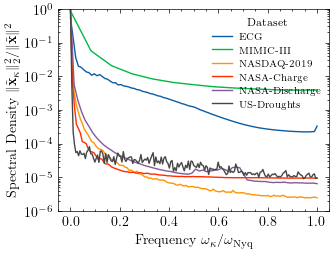

In [63]:
ax = sns.lineplot(data=spectral_df,x="Normalized Frequency", y="Normalized Spectral Density", hue="Dataset")
plt.ylabel(r"Spectral Density $\|\tilde{\mathbf{x}}_\kappa\|^2_2  /  \| \tilde{\mathbf{x}} \|^2$")
plt.hlines(0, 0, 1, colors="black", linestyles="dashed")
plt.xlabel(r" Frequency $\omega_\kappa  /  \omega_{\mathrm{Nyq}}$")
plt.yscale("log")
plt.ylim(top=1, bottom=1e-6)
plt.legend(fontsize=7, title="Dataset", title_fontsize=8)
plt.savefig(save_dir / "figures" / "spectral_density_datasets.pdf", bbox_inches="tight")
plt.show()

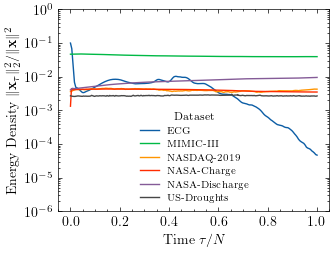

In [64]:
sns.lineplot(data=temporal_df, x="Normalized Time", y="Normalized Energy", hue="Dataset") 
plt.ylabel(r"Energy Density $\|\mathbf{x}_\tau \|^2_2 / \| \mathbf{x} \|^2$")
plt.xlabel(r"Time $\tau / N$")
plt.yscale("log")
plt.ylim(top=1, bottom=1e-6)
plt.legend(fontsize=7, title="Dataset", title_fontsize=8, loc="lower center")
plt.savefig(save_dir / "figures" / "temporal_energy_datasets.pdf", bbox_inches="tight")
plt.show()

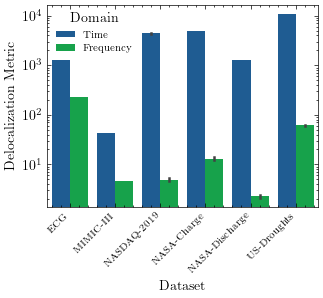

In [7]:
ax = sns.barplot(data=localization_df, x="Dataset", y="Delocalization", hue="Domain")
ax.set_yscale('log')
plt.xticks(rotation=45, ha='right', fontsize=7)
plt.ylabel("Delocalization Metric")
plt.legend(loc='upper left', fontsize=7, title="Domain")
plt.savefig(save_dir / "figures" / "localization_datasets.pdf", bbox_inches="tight")
plt.show()


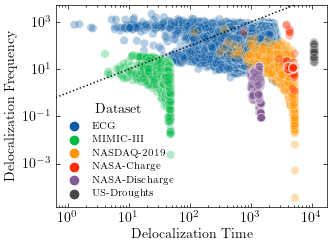

In [8]:
ax = sns.scatterplot(data=localization_joint_df, x="Delocalization Time", y="Delocalization Frequency", hue="Dataset", alpha=0.3)
ax.set_yscale('log')
ax.set_xscale('log')
ax.axline((1, 1),  (10, 10  ), color="black", linestyle=":")
plt.legend(loc='lower left', fontsize=7, title="Dataset")
plt.savefig(save_dir / "figures" / "localization_joint_datasets.pdf", bbox_inches="tight")
plt.show()

# Delocalization of ECG by Gaussian Convolution

In [18]:
def infer_diffusion_domain(config: dict[str, Any]) -> str:
    fourier_transform = config["fourier_transform"]
    if fourier_transform:
        return "Frequency"
    else:
        return "Time"


def calculate_metrics(results: dict) -> list[dict]:
    data = []
    for domain, method in product({"time", "freq"}, {"sliced", "marginal"}):
        all_distances = results[f"{domain}_{method}_wasserstein_all"]
        data.extend(
            [
                {
                    "Value": distance,
                    "Metric Domain": "Frequency" if domain == "freq" else "Time",
                    "Metric": "Sliced Wasserstein"
                    if method == "sliced"
                    else "Marginal Wasserstein",
                }
                for distance in all_distances
            ]
        )
    return data

In [19]:
run_list = [
    "zdziznic",
    "va4krqr6",
    "bf3lrfx9",
    "emk7nyz3",
    "2adxm708",
    "zj9secov",
    "np2b68ru",
    "eho1sajh",
    "r9nol7jo",
    "qr1ukbne",
]
runs_dir = Path.cwd() / "../lightning_logs/"

In [20]:
data_path = Path.cwd() / "../data/"

dm = ECGDatamodule(data_dir=data_path)
dm.prepare_data()
dm.setup()
X_train = dm.X_train

In [21]:
df_ecg_conv = []

for run in run_list:
    with open(runs_dir / f"{run}/train_config.yaml", "r") as f:
        config = safe_load(f)
        domain = infer_diffusion_domain(config)
        sigma = config["datamodule"].get("smoother_width", 0.0)
    
    with open(runs_dir / f"{run}/results.yaml", "r") as f:
        results = safe_load(f)
        df = pd.DataFrame(calculate_metrics(results))
    
   
    X_train_new = smooth_frequency(X_train, sigma) if sigma > 0 else X_train
    X_loc, X_spec_loc = localization_metrics(X_train_new)
    
    df["Gaussian Kernel Width"] = sigma
    df["Time Delocalization"] = X_loc.mean().item()
    df["Frequency Delocalization"] = X_spec_loc.mean().item()
    df["Diffusion Domain"] = domain
    
    df_ecg_conv.append(df)

df_ecg_conv = pd.concat(df_ecg_conv)
df_ecg_conv.head()

,Value,Metric Domain,Metric,Gaussian Kernel Width,Time Delocalization,Frequency Delocalization,Diffusion Domain
0,0.000636,Frequency,Sliced Wasserstein,10.0,50.820747,1016.156311,Time
1,0.000246,Frequency,Sliced Wasserstein,10.0,50.820747,1016.156311,Time
2,0.000197,Frequency,Sliced Wasserstein,10.0,50.820747,1016.156311,Time
3,0.000447,Frequency,Sliced Wasserstein,10.0,50.820747,1016.156311,Time
4,0.000701,Frequency,Sliced Wasserstein,10.0,50.820747,1016.156311,Time


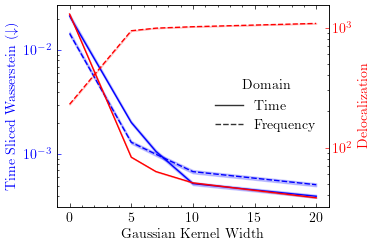

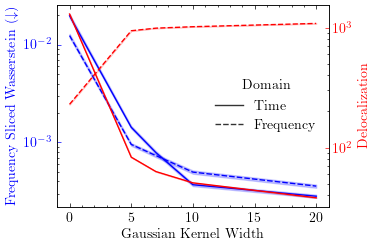

In [22]:
for metric_domain in ["Time", "Frequency"]:
    
    df_ecg_conv_filter = df_ecg_conv[(df_ecg_conv["Metric"] == "Sliced Wasserstein") & (df_ecg_conv["Metric Domain"] == metric_domain)]
    ax = sns.lineplot(data=df_ecg_conv_filter, x="Gaussian Kernel Width", y="Value", style="Diffusion Domain", color="blue")
    ax.set_yscale('log')
    ax.set_ylabel(f"{metric_domain} Sliced Wasserstein ($\downarrow$)", color="blue")
    ax.legend(title="Domain", loc='center right')
    ax.tick_params(axis='y', colors='blue')
        
    
    ax2 = ax.twinx()
    sns.lineplot(data=df_ecg_conv_filter, x="Gaussian Kernel Width", y="Time Delocalization", ax=ax2, color="red", linestyle="-")
    sns.lineplot(data=df_ecg_conv_filter, x="Gaussian Kernel Width", y="Frequency Delocalization", ax=ax2, color="red", linestyle="--")
    ax2.set_ylabel("Delocalization", color="red")
    ax2.tick_params(axis='y', colors='red')
    ax2.set_yscale('log')

    plt.savefig(save_dir / "figures" / f"ecg_conv_{metric_domain.lower()}.pdf", bbox_inches="tight")    
    plt.show()
    plt.close()